# 🔴 Selecting red clump stars from Gaia DR3 with good GSP-Spec abundances

We start with this query, which selects stars whose location in a colour-absolute magnitude diagram (not corrected for extinction) is within 0.4 mag of the fiducial line corresponding to the red clump:

```sql
    select * from
    ( select ra,dec,l,b,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,
    nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved,
    source_id, parallax, parallax_error,
    phot_g_mean_mag-phot_rp_mean_mag as g_rp,
    phot_g_mean_mag + 5 + 5*log10(parallax/1000.) as gabs,
    0.22735803*POWER(g_rp,4) +  0.29834927*POWER(g_rp,3) +  1.15739006*POWER(g_rp,2) +  1.07531329*g_rp -0.83172317 as poly5
    from gaiadr3.gaia_source
    where phot_g_mean_mag<14 and parallax>0)
    as subquery
    where subquery.gabs<(subquery.poly5+0.4) and subquery.gabs>(subquery.poly5-0.4)
```
    
We limited the query to $G<14$ to save time, because we know that later in this analysis we will be working with the stars with the most precise chemical abundances, and we know that none of them are fainter than 14.

The resulting file `rc14_04-result.fits.gz` (220MB) can be downloaded from Zenodo: https://zenodo.org/records/10628724

In this notebook we will immediately refine this selection by correcting the parallaxes with the ``zpt`` code which implements the Lindegren et al. (2021) parallax correction:

https://gitlab.com/icc-ub/public/gaiadr3_zeropoint

https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...4L/abstract

and retain stars within 0.3 mag of the fiducial line. The typical parallax uncertainties in this sample is 0.015 mas. **Given the parallax and error distribution within the sample, the $\pm0.3$ mag selection is expected to miss less than 0.015% of the red clump stars due to parallax noise.**

## Correcting Gaia parallaxes

In [1]:
%%time
from astropy.table import Table
tAllRedClump_G14 = Table.read('rc14_04-result.fits.gz') # file available at https://zenodo.org/records/10628724

CPU times: user 3.68 s, sys: 427 ms, total: 4.11 s
Wall time: 3.84 s


In [2]:
%%time
from zpt import zpt5, zpt6
import numpy as np


allZpt = []

for row in tAllRedClump_G14:
    ggg = row['phot_g_mean_mag']
    nnn = row['nu_eff_used_in_astrometry']
    ppp = row['pseudocolour']
    eee = np.sin( np.radians(row['ecl_lat']) )

    #print( ggg , nnn , ppp , eee )
    try:
        allZpt.append( zpt5( ggg , nnn , eee ) )
    except:
        allZpt.append( zpt6( ggg , ppp , eee ) )

CPU times: user 2min 11s, sys: 496 ms, total: 2min 12s
Wall time: 2min 12s


Recompute Gabs, and keep stars within 0.3 mag of the new value:

In [3]:
tAllRedClump_G14["corrected_parallax"] = tAllRedClump_G14["parallax"] - np.array(allZpt)
tAllRedClump_G14["gabs"] = (
    tAllRedClump_G14["phot_g_mean_mag"]
    + 5
    + 5 * np.log10(tAllRedClump_G14["corrected_parallax"] / 1000.0)
)
tAllRedClump_G14 = tAllRedClump_G14[
    tAllRedClump_G14["gabs"] < (tAllRedClump_G14["poly5"] + 0.3)
]
tAllRedClump_G14 = tAllRedClump_G14[
    tAllRedClump_G14["gabs"] > (tAllRedClump_G14["poly5"] - 0.3)
]
tAllRedClump_G14 = tAllRedClump_G14[tAllRedClump_G14["g_rp"] > 0.6]
tAllRedClump_G14 = tAllRedClump_G14[tAllRedClump_G14["g_rp"] < 1.2]
tAllRedClump_G14.write("rc14_03.fits", overwrite=True)

## Sample of stars with good GSP-Spec abundances

We used the combination of quality flags listed in Appendix B (Listing 3) of Gaia collaboration, Recio-Blanco et al. (2023A&A...674A..38G) to retrieve a list of stars with precise metallicities and alpha abundances obtained with the Gaia GSP-Spec pipeline. We downloaded this file locally and performed the parallax correction. The resulting 420MB fits table `full_gradient_corrected_parallax.fits` can be downloaded from here: https://zenodo.org/records/10628724

In [4]:
tGaiaGSPSpec = Table.read("full_gradient_corrected_parallax.fits")

# Calibrated abundances (see paper):
coefsMET = [2.98830221e-04, -1.47790455e00]
coefsALPHA = [-0.04481355, -0.04413965]
tGaiaGSPSpec["mh_gspspec_corr"] = tGaiaGSPSpec["mh_gspspec"] - np.polyval(
    coefsMET, tGaiaGSPSpec["teff_gspspec"]
)
tGaiaGSPSpec["alphafe_gspspec_corr"] = tGaiaGSPSpec["alphafe_gspspec"] - np.polyval(
    coefsALPHA, tGaiaGSPSpec["mh_gspspec"]
)

We now add an even more stringent precision condition: we want abundances with a total error smaller than 0.1 dex.

In [5]:
alphaErrorGaia = (
    tGaiaGSPSpec["alphafe_gspspec_upper"] - tGaiaGSPSpec["alphafe_gspspec_lower"]
)
feErrorGaia = tGaiaGSPSpec["mh_gspspec_upper"] - tGaiaGSPSpec["mh_gspspec_lower"]
chemErr = np.sqrt(alphaErrorGaia**2 + feErrorGaia**2)
tGaiaGSPSpec["chemErr"] = chemErr

tGaiaGSPSpec = tGaiaGSPSpec[chemErr <= 0.1]

## Completeness of the good GSP-Spec red clump sample

We match ``tAllRedClump_G14`` with ``tGaiaGSPSpec``.

We first construct the selection function as a function of G magnitude and sky position. 

In [6]:
from astropy.table import join

tJoined = join(tAllRedClump_G14, tGaiaGSPSpec, keys="source_id", join_type="left")
# to easily remove the empty rows:
tJoined["chemErr"].fill_value = np.nan
tJoined["chemErr"] = tJoined["chemErr"].filled()
#
tJoined["mh_gspspec_corr"].fill_value = np.nan
tJoined["mh_gspspec_corr"] = tJoined["mh_gspspec_corr"].filled()

/var/folders/k7/66g0jm190792cl33xj3stcy08wrsw2/T/ipykernel_32544/4023048470.py:18: RuntimeWarning: invalid value encountered in divide
  plt.plot( binsG[:-1]+0.25 , 100 * H_goodRC / H_allRC , c='#aaaaaa')
/var/folders/k7/66g0jm190792cl33xj3stcy08wrsw2/T/ipykernel_32544/4023048470.py:22: RuntimeWarning: invalid value encountered in divide
  plt.plot( binsG[:-1]+0.25 , 100 * H_goodRC / H_allRC , c='k',lw=3)


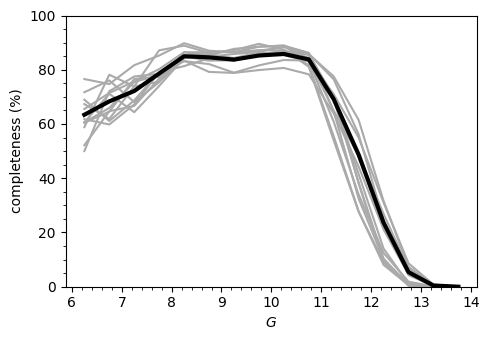

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3.5))


binsG = np.arange(0, 14.5, 0.5)


hpx0 = tJoined["source_id"] // 2 ** (59 - 2 * 0)
for iHpx in range(12):
    H_allRC, _ = np.histogram(tJoined["phot_g_mean_mag_1"][hpx0 == iHpx], bins=binsG)
    H_goodRC, _ = np.histogram(
        tJoined["phot_g_mean_mag_1"][(hpx0 == iHpx) & (tJoined["chemErr"] > 0)],
        bins=binsG,
    )
    plt.plot(binsG[:-1] + 0.25, 100 * H_goodRC / H_allRC, c="#aaaaaa")

H_allRC, _ = np.histogram(tJoined["phot_g_mean_mag_1"][hpx0 > -1], bins=binsG)
H_goodRC, _ = np.histogram(
    tJoined["phot_g_mean_mag_1"][(hpx0 > -1) & (tJoined["chemErr"] > 0)], bins=binsG
)
plt.plot(binsG[:-1] + 0.25, 100 * H_goodRC / H_allRC, c="k", lw=3)

plt.xlabel("$G$")
plt.ylabel("completeness (%)")
plt.ylim(0, 100)
plt.minorticks_on()

plt.tight_layout()

# plt.savefig('figures/completenes_rc-gsp-spec.pdf',bbox_inches='tight')

Only 2% of the sources are brighter than G=8, and 0.5% fainter than 13, so we bin them in those magnitude ranges:

* 6 to 10.5

* then five bins of 0.5

* zero if G<6 or G>13

Let's look at how fine we can make the bins on the sky.

0
1
2
3
4
5
6
CPU times: user 3min 36s, sys: 3 s, total: 3min 39s
Wall time: 3min 37s


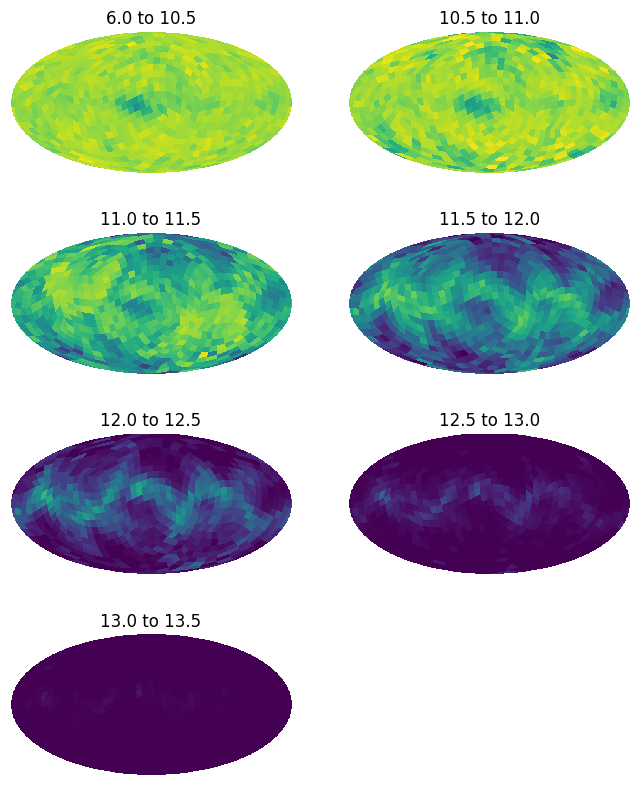

In [8]:
%%time
import healpy as hp

gbins = [[6,10.5],
        [10.5,11],
        [11.,11.5],
        [11.5,12],
        [12,12.5],
        [12.5,13],
        [13,13.5]]

hpxOrder = 3

ratios_GOOD_gspspec = []

plt.figure(figsize=(8,10))

for iBin, (gmin,gmax) in enumerate(gbins):
    print(iBin)
    tMagSlice = tJoined[ (tJoined['phot_g_mean_mag_1']>gmin) & (tJoined['phot_g_mean_mag_1']<gmax) ]
    hpxNumber = tMagSlice['source_id'] // 2**(59-2*hpxOrder)
    countsALL = np.array([len(t) for t in [tMagSlice[hpxNumber==N] for N in range(12*4**hpxOrder)] ])
    #
    tMagSliceGOOD = tMagSlice[tMagSlice['chemErr']>0]
    hpxNumber = tMagSliceGOOD['source_id'] // 2**(59-2*hpxOrder)
    countsGOOD = np.array([len(t) for t in [tMagSliceGOOD[hpxNumber==N] for N in range(12*4**hpxOrder)] ])
    ratios = countsGOOD / countsALL 
    
    #keep the results:
    ratios_GOOD_gspspec.append( ratios )
    
    ttt = '%.1f to %.1f' % (gmin,gmax)
    plt.subplot(4,2,iBin+1)
    hpMap = hp.mollview(ratios,coord = 'CG',nest=True,
                min=0,max=1.,hold=True,title=ttt,notext=True,cbar=False)

0
1
2
3
4
5
6
CPU times: user 3min 31s, sys: 2.48 s, total: 3min 34s
Wall time: 3min 31s


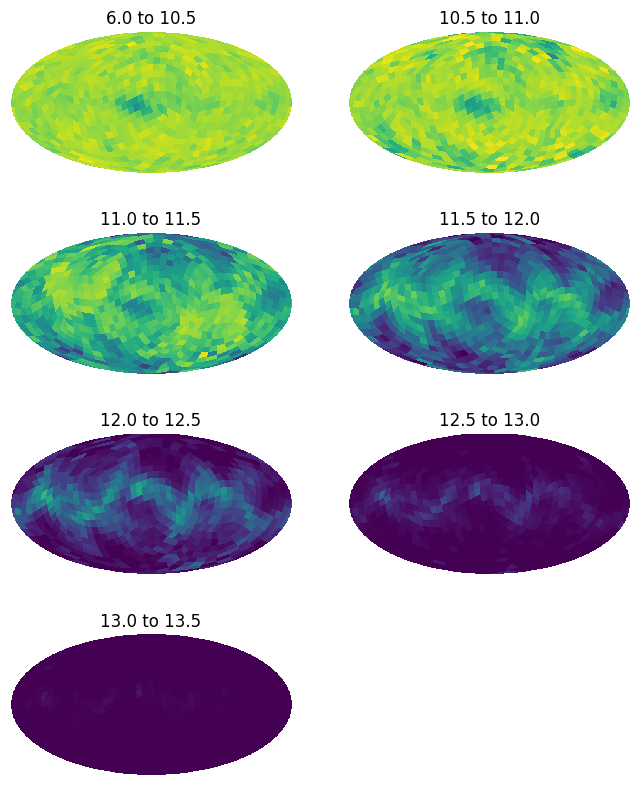

In [9]:
%%time
import healpy as hp

gbins = [[6,10.5],
        [10.5,11],
        [11.,11.5],
        [11.5,12],
        [12,12.5],
        [12.5,13],
        [13,13.5]]

hpxOrder = 3

ratios_GOOD_gspspec = []

plt.figure(figsize=(8,10))

for iBin, (gmin,gmax) in enumerate(gbins):
    print(iBin)
    tMagSlice = tJoined[ (tJoined['phot_g_mean_mag_1']>gmin) & (tJoined['phot_g_mean_mag_1']<gmax) ]
    hpxNumber = tMagSlice['source_id'] // 2**(59-2*hpxOrder)
    countsALL = np.array([len(t) for t in [tMagSlice[hpxNumber==N] for N in range(12*4**hpxOrder)] ])
    #
    tMagSliceGOOD = tMagSlice[tMagSlice['chemErr']>0]
    hpxNumber = tMagSliceGOOD['source_id'] // 2**(59-2*hpxOrder)
    countsGOOD = np.array([len(t) for t in [tMagSliceGOOD[hpxNumber==N] for N in range(12*4**hpxOrder)] ])
    ratios = countsGOOD / countsALL 
    
    #keep the results:
    ratios_GOOD_gspspec.append( ratios )
    
    ttt = '%.1f to %.1f' % (gmin,gmax)
    plt.subplot(4,2,iBin+1)
    hpMap = hp.mollview(ratios,coord = 'CG',nest=True,
                min=0,max=1.,hold=True,title=ttt,notext=True,cbar=False)

Order 4 becomes too noisy over most of the sky. Example for one magnitude range:

0
CPU times: user 1min 29s, sys: 1.03 s, total: 1min 30s
Wall time: 1min 30s


<timed exec>:18: RuntimeWarning: invalid value encountered in divide


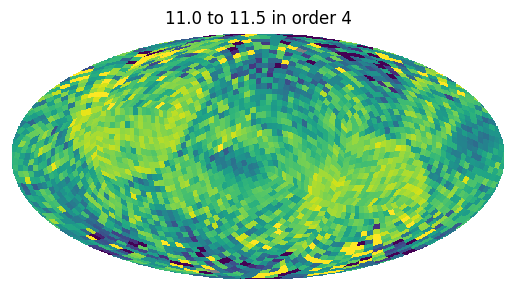

In [10]:
%%time
import healpy as hp

gbins = [[11.,11.5]]

hpxOrder = 4

plt.figure()

for iBin, (gmin,gmax) in enumerate(gbins):
    print(iBin)
    tMagSlice = tJoined[ (tJoined['phot_g_mean_mag_1']>gmin) & (tJoined['phot_g_mean_mag_1']<gmax) ]
    hpxNumber = tMagSlice['source_id'] // 2**(59-2*hpxOrder)
    countsALL = np.array([len(t) for t in [tMagSlice[hpxNumber==N] for N in range(12*4**hpxOrder)] ])
    #
    tMagSliceGOOD = tMagSlice[tMagSlice['chemErr']>0]
    hpxNumber = tMagSliceGOOD['source_id'] // 2**(59-2*hpxOrder)
    countsGOOD = np.array([len(t) for t in [tMagSliceGOOD[hpxNumber==N] for N in range(12*4**hpxOrder)] ])
    ratios = countsGOOD / countsALL 
    
    ttt = '%.1f to %.1f in order 4' % (gmin,gmax)
    hpMap = hp.mollview(ratios,coord = 'CG',nest=True,
                min=0,max=1.,hold=True,title=ttt,notext=True,cbar=False)

We wrap all those precomputed maps into a function which takes coordinates and magnitude as input.

The ``offset`` parameter is explained further down. We will use it to tune the selection function to stellar populations of different metallicities.

In [11]:
import astropy_healpix as ah


def SF_gaiaChem(coords, gmag, offset=0):
    """
    Input:
        coords: coordinates (astropy SkyCoord object, or array of)
        gmag:  apparent G magnitude (float)
        offset: negative value for metal-poor stars, positive for metal-rich

    Output: float between 0 and 1
    """
    ra = coords.ra
    dec = coords.dec

    nside = 8  # corresponds to healpix order 3, which we used to pre-compute the ratios

    if gmag < 6 or gmag > 13 + offset:
        return np.zeros((len(coords), 1))

    else:
        if gmag < 10.5 + offset:
            iMagSlice = 0
        elif gmag < 11 + offset:
            iMagSlice = 1
        elif gmag < 11.5 + offset:
            iMagSlice = 2
        elif gmag < 12 + offset:
            iMagSlice = 3
        elif gmag < 12.5 + offset:
            iMagSlice = 4
        elif gmag < 13 + offset:
            iMagSlice = 5
        else:
            iMagSlice = 6

    ipix = ah.lonlat_to_healpix(ra, dec, nside, order="nested")
    return np.array([[ratios_GOOD_gspspec[iMagSlice][iii] for iii in ipix]])

Plotting all-sky completeness map at G=10.00
Plotting all-sky completeness map at G=11.10
Plotting all-sky completeness map at G=11.60
Plotting all-sky completeness map at G=12.60
CPU times: user 2.19 s, sys: 443 ms, total: 2.63 s
Wall time: 1.54 s


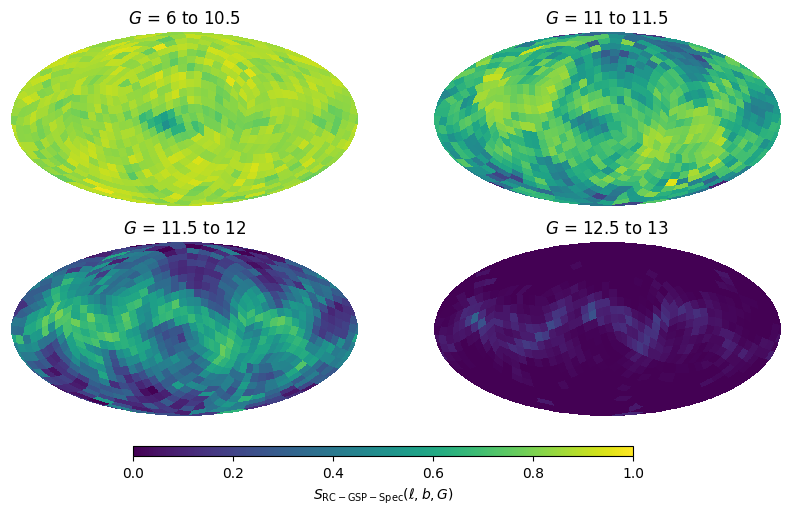

In [12]:
%%time
from gaiaunlimited import utils
coords_of_centers = utils.get_healpix_centers(5)

import healpy as hp

fig = plt.figure(figsize=(10,5))


    
for iii,G in enumerate([10,11.1,11.6,12.6]):
    print('Plotting all-sky completeness map at G=%.2f' % (G))
    plt.subplot(2,2,iii+1)
    ssff = SF_gaiaChem(coords_of_centers,G)
    
    ttt = 'G = %.2f' % (G)
    if G==10:
        ttt = '$G$ = 6 to 10.5'
    if G==11.10:
        ttt = '$G$ = 11 to 11.5'
    if G==11.60:
        ttt = '$G$ = 11.5 to 12'
    if G==12.60:
        ttt = '$G$ = 12.5 to 13'
        
    hpMap = hp.mollview(ssff.flatten(),coord = 'CG',nest=False,
                min=0,max=1.,hold=True,title=ttt,notext=True,cbar=False)

#add a fifth ax, which will contain the colorbar only
cax = fig.add_axes([0.25, 0.03, 0.5, 0.02])
fig.colorbar(hpMap,cax=cax,orientation='horizontal',
             label='$S_{\mathrm{RC-GSP-Spec}} (\ell,b,G)$')

#plt.savefig('figures/gaia_chem_SF_allsky_fourpanels.pdf',bbox_inches='tight')

## From S(l,b,G) to a selection function in positional space

We use the 3D extinction map of Lallement et al. (2022) to predict the apparent magnitude of a red clump star at any location (l,b,distance)=(X,Y,Z) in the Milky Way.

We convert the $A_0$ provided by the map to $A_G$ for the typical effective temperature of a red clump star using the dustapprox table: https://github.com/mfouesneau/dustapprox

In [13]:
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord

from dustmaps import lallement2022

lallement2022.fetch()
lll = lallement2022.LallementQuery()


def a0_to_ag(azero):
    """
    2nd order polynomial fit to the pre-computed dustapprox table:
    https://github.com/mfouesneau/dustapprox/raw/main/docs/models/precomputed/kurucs_gaiaedr3_small_a0_grid.csv

    at teff = 4750 K
       logg = 2.5
       FeH  = 0

    """
    coefs = [-0.01393148, 0.80373037, 0.0]
    return np.polyval(coefs, azero)

File appears to exist already. Call `fetch(clobber=True)` to force overwriting of existing file.


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340


/opt/anaconda3/envs/GU/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in rxp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 16.5 s, sys: 297 ms, total: 16.8 s
Wall time: 16.4 s


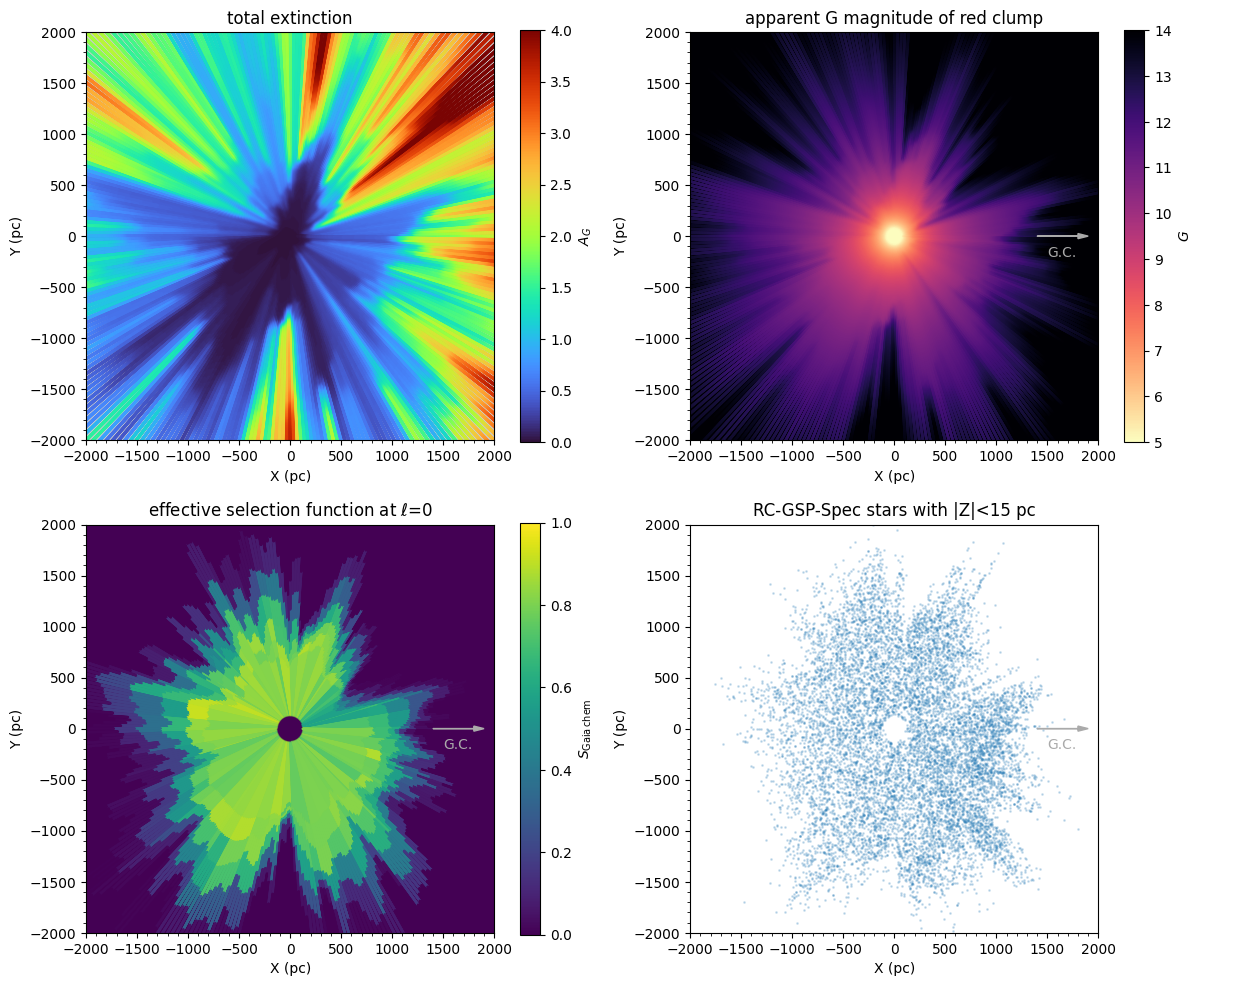

In [14]:
%%time
#
# This is the 4-panel figure for the paper
#
import astropy.units as units

fig = plt.figure(figsize=(12.5,10))

ax2 = fig.add_subplot(221,aspect=1)
plt.title('total extinction')
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.minorticks_on()
plt.xlim(-2000,2000)
plt.ylim(-2000,2000)
ax2.set_facecolor('#cccccc')


ax3 = fig.add_subplot(222,aspect=1)
plt.title('apparent G magnitude of red clump')
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.minorticks_on()
plt.xlim(-2000,2000)
plt.ylim(-2000,2000)
ax3.set_facecolor('#000004')


ax4 = fig.add_subplot(223,aspect=1)
plt.title('effective selection function at $\ell$=0')
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.minorticks_on()
plt.xlim(-2000,2000)
plt.ylim(-2000,2000)
ax4.set_facecolor('#440154')


dd = np.arange(5,3000,5)

all_X = []
all_Y = []
all_SSFF = []

for ll in np.arange(0,360,1):
    b_to_use = 0

    coordsLoS = SkyCoord(l=ll*np.ones_like(dd)*units.deg,
                         b=b_to_use*np.ones_like(dd)*units.deg,
                         distance=dd*units.pc, frame='galactic')
    a0_dustmaps = lll(coordsLoS)
    xx = coordsLoS.cartesian.x / units.pc
    yy = coordsLoS.cartesian.y / units.pc
    
    totalAG = 5*np.cumsum(a0_to_ag(a0_dustmaps))
    totExt = ax2.scatter( xx , yy , c=totalAG , s=2 , vmin=0 , vmax=4., 
                         cmap='turbo',zorder=-10)
    
    apparentGofRC = 0.50 + totalAG + 5*np.log10(dd)-5
    apparentG = ax3.scatter( xx , yy , c=apparentGofRC , s=1 , vmin=5 , vmax=14,
                            cmap='magma_r',zorder=-10)

    if ll%20==0:
        print(ll)
        
    # single point on the sky:
    singlepointcoord = SkyCoord(l=[ll]*units.deg,
                             b=[0]*units.deg,
                            frame='galactic').transform_to(coord.ICRS)

    for iii,aaa in enumerate(apparentGofRC):
        ssff = SF_gaiaChem( singlepointcoord , aaa )[0][0]
        all_X.append( xx[iii] )
        all_Y.append( yy[iii] )
        all_SSFF.append( ssff )
        #sss = ax4.scatter( xx[iii] , yy[iii] , c=ssff , s=1 , vmin=0 , vmax=1)

plt.colorbar(totExt,ax=ax2,label='$A_G$')
plt.colorbar(apparentG,ax=ax3,label='$G$')
sss = ax4.scatter( all_X , all_Y , c=all_SSFF , s=1 , vmin=0 , vmax=1, rasterized=True)
plt.colorbar(sss,ax=ax4,label='$S_{\mathrm{Gaia\,chem}}$')



# - - - - - - -
#
#     This block plots the XY distribution of our RC sample
#
# - - - - - - -

ax1 = fig.add_subplot(224,aspect=1)
plt.title('RC-GSP-Spec stars with |Z|<15 pc')
#
tJoined['distance'] = 1000./tJoined['corrected_parallax_2']
# set masked distance to infinity:
tJoined['distance'].fill_value = np.inf
tJoined['distance'] = tJoined['distance'].filled()
tJoined['distance'].unit = 'pc'
c_Gaia = SkyCoord(ra=tJoined['ra_2'],dec=tJoined['dec_2'],distance=tJoined['distance'],unit='deg,deg,pc')
c_Gaia_xyz = c_Gaia.transform_to(coord.Galactocentric)
xx = c_Gaia_xyz.x
yy = c_Gaia_xyz.y
zz = c_Gaia_xyz.z
xx=xx[np.abs(zz.value-0)<15]
yy=yy[np.abs(zz.value-0)<15]
gforslice = tJoined['phot_g_mean_mag_2'][np.abs(zz.value-0)<15]
#
plt.scatter( xx + 8122*units.pc , yy , s=1 , alpha=0.2, rasterized=False)

# for invisible colorbar:
plt.scatter( [0] , [0] , c=[0],alpha=0)
cb=plt.colorbar()
cb.outline.set_edgecolor('white')
cb.set_label('colorbar label', color='white')
cb.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.minorticks_on()
plt.xlim(-2000,2000)
plt.ylim(-2000,2000)


## arrow in XY scatter plot:
plt.arrow(1400, 0, 500, 0, length_includes_head=True,
         head_width=50,head_length=100, color='#AAAAAA')
plt.text(1500,-200,'G.C.', color='#AAAAAA')


## arrow in SF plot:
ax4.arrow(1400, 0, 500, 0, length_includes_head=True,
         head_width=50,head_length=100, color='#AAAAAA',zorder=10)
ax4.text(1500,-200,'G.C.', color='#AAAAAA',zorder=10)
## arrow in Gmag plot:
ax3.arrow(1400, 0, 500, 0, length_includes_head=True,
         head_width=50,head_length=100, color='#AAAAAA',zorder=10)
ax3.text(1500,-200,'G.C.', color='#AAAAAA',zorder=10)

plt.tight_layout()
ax2.set_rasterization_zorder(0)
ax3.set_rasterization_zorder(0)
#plt.savefig('figures/gaia_chem_SF_XY.pdf',dpi=100,bbox_inches='tight')

## The selection function also depends on metallicity

The selection function for our sample of stars with precise GSP-Spec abundances depends on metallicity, because the spectra of metal-poor stars have less visible absorption lines, so they require a higher signal-to-noise ratio. This means that the limiting magnitude for the metal-rich red clump stars is fainter than for the metal-poor ones, and the corresponding volume is smaller.

Peaks at: 10.825000000000015
Peaks at: 11.375000000000023
Peaks at: 11.975000000000032
Peaks at: 12.325000000000037
Peaks at: 12.325000000000037


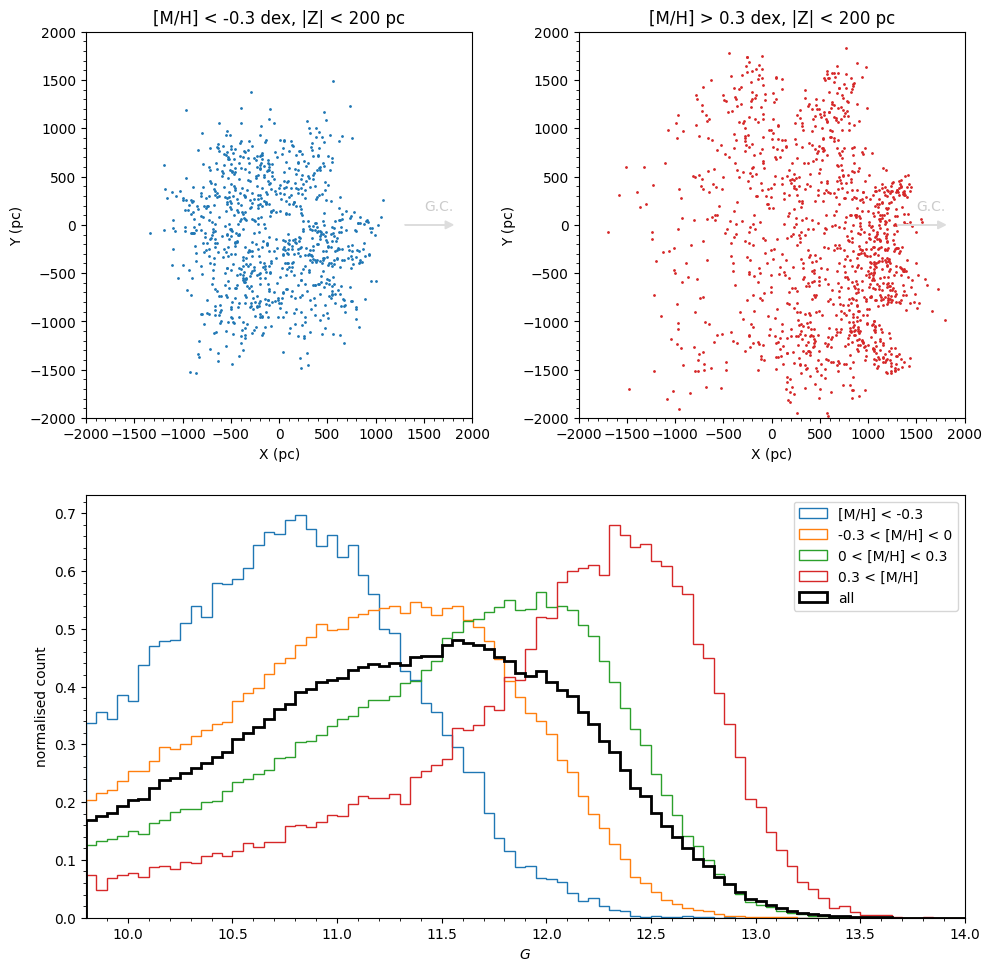

In [15]:
zmax = 20
xx = c_Gaia_xyz.x
yy = c_Gaia_xyz.y
zz = c_Gaia_xyz.z
xx = xx[np.abs(zz.value - 0) < zmax]
yy = yy[np.abs(zz.value - 0) < zmax]
mh = tJoined["mh_gspspec_corr"][np.abs(zz.value - 0) < zmax]


fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(221, aspect=1)
plt.scatter(
    xx[mh < -0.3] + 8122 * units.pc,
    yy[mh < -0.3],
    s=1,
    alpha=1.0,
    rasterized=False,
    c="C0",
)
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.minorticks_on()
plt.xlim(-2000, 2000)
plt.ylim(-2000, 2000)
plt.title("[M/H] < -0.3 dex, |Z| < 200 pc")
## arrow to GC:
plt.arrow(
    1300,
    0,
    500,
    0,
    length_includes_head=True,
    head_width=80,
    head_length=80,
    color="#DDDDDD",
    zorder=10,
)
plt.text(1500, 150, "G.C.", color="#CCCCCC", zorder=10)


ax2 = fig.add_subplot(222, aspect=1)
plt.scatter(
    xx[mh > 0.3] + 8122 * units.pc,
    yy[mh > 0.3],
    s=1,
    alpha=1.0,
    rasterized=False,
    c="C3",
)
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.minorticks_on()
plt.xlim(-2000, 2000)
plt.ylim(-2000, 2000)
plt.title("[M/H] > 0.3 dex, |Z| < 200 pc")
## arrow to GC:
plt.arrow(
    1300,
    0,
    500,
    0,
    length_includes_head=True,
    head_width=80,
    head_length=80,
    color="#DDDDDD",
    zorder=10,
)
plt.text(1500, 150, "G.C.", color="#CCCCCC", zorder=10)


G_of_peak = []

labels = ["[M/H] < -0.3", "-0.3 < [M/H] < 0", "0 < [M/H] < 0.3", "0.3 < [M/H]"]

plt.subplot(212)
binsG = np.arange(9.8, 14.1, 0.05)
for iii, (mh_min, mh_max) in enumerate(
    [[-np.inf, -0.3], [-0.3, 0], [0, 0.3], [0.3, np.inf]]
):
    keep = (tJoined["mh_gspspec_corr"] > mh_min) & (tJoined["mh_gspspec_corr"] < mh_max)
    H = plt.hist(
        tJoined["phot_g_mean_mag_2"][keep],
        histtype="step",
        bins=binsG,
        density=True,
        label=labels[iii],
    )

    Gpeak = binsG[np.argmax(H[0])]
    print("Peaks at:", Gpeak + 0.025)
    G_of_peak.append(Gpeak)

keep = (tJoined["mh_gspspec_corr"] > -1) & (tJoined["mh_gspspec_corr"] < 1)
H = plt.hist(
    tJoined["phot_g_mean_mag_2"][keep],
    histtype="step",
    bins=binsG,
    density=True,
    color="k",
    lw=2,
    label="all",
)
Gpeak_all = binsG[np.argmax(H[0])]
print("Peaks at:", Gpeak + 0.025)


plt.xlim(9.8, 14)
plt.minorticks_on()
plt.xlabel("$G$")
plt.ylabel("normalised count")
plt.legend()

plt.tight_layout()
# plt.savefig('figures/sf_with_metallicity.pdf',bbox_inches='tight')

We can also verify that in all metallicity groups, the faintest stars are distributed along the ridges of high Gaia scan rates:

/var/folders/k7/66g0jm190792cl33xj3stcy08wrsw2/T/ipykernel_32544/2977086261.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


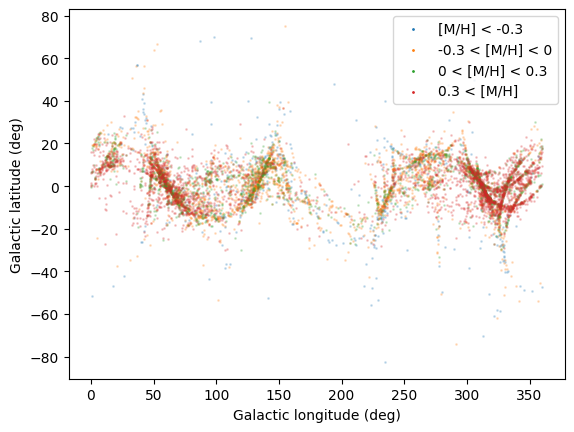

In [16]:
for iii, (mh_min, mh_max) in enumerate(
    [[-np.inf, -0.3], [-0.3, 0], [0, 0.3], [0.3, np.inf]]
):
    keep = (tJoined["mh_gspspec_corr"] > mh_min) & (tJoined["mh_gspspec_corr"] < mh_max)
    faintestG = max(tJoined["phot_g_mean_mag_2"][keep])
    keep[tJoined["phot_g_mean_mag_2"] < (faintestG - 1.0)] = False
    plt.scatter(
        tJoined["l"][keep], tJoined["b"][keep], s=1, label=labels[iii], alpha=0.2
    )

plt.xlabel("Galactic longitude (deg)")
plt.ylabel("Galactic latitude (deg)")
leg = plt.legend(loc="upper right")
for lh in leg.legendHandles:
    lh.set_alpha(1)

We tune the selection function for each metallicity range by computing the magnitude difference between their G-magn distribution peak and the peak of the overall sample.

The value of ``delta_for_SF`` is negative for the metal-poor populations and positive for metal-rich, so we will *subtract* its value from the apparent G mag.

In [17]:
delta_for_SF = np.array(G_of_peak) - Gpeak_all
print(delta_for_SF)

[-0.75 -0.2   0.4   0.75]
